CHRISTIAN CAMILO GARZON VASQUEZ


---


FUNDAMENTOS DE DEEP LEARNING

FACULTAD DE INGENIERIA

UNIVERSIDAD DE ANTIOQUIA


---




#**PRIMER ACERCAMIENTO**
#**PERCEPTRON SIMPLE**

**BASADO EN:** https://www.tensorflow.org/tutorials/structured_data/imbalanced_data Y NOTAS DE CLASE

# 0. LIBRERIAS REQUERIDAS

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Activation
import os
import tempfile
import matplotlib as mpl
from matplotlib import pylab as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. CARGA DE DATOS Y ANÁLISIS INICIAL

In [ ]:
#Creando DataFrame
df = pd.DataFrame()

In [ ]:
#Asegurate de tener el archivo "data_bin_desbalanceada.csv" en la misma carpeta
df = pd.read_csv('data_bin_desbalanceada.csv')
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0


#2. DIVIDIENDO DATASET ENTRE CONJUNTOS DE ENTRENO, TESTEO Y VALIDACION



In [ ]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)] #Evitando valores NaN e inf 

#Usando sklearn para dividir dataset cargado
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#Tomando características y etiquetas de los arrays Form np arrays of labels and features
train_labels = np.array(train_df.pop(' Label')) #Tomando etiquetas de entrenamiento
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(' Label')) #Tomando etiquetas de validacion
test_labels = np.array(test_df.pop(' Label')) #Tomando etiquetas de testeo

train_features = np.array(train_df) #Tomando caracteristícas de entrenamiento
val_features = np.array(val_df) #Tomando caracteristícas de validación
test_features = np.array(test_df) #Tomando caracteristícas de testeo

In [ ]:
scaler = StandardScaler() #Normalizar datos
train_features = scaler.fit_transform(train_features) #Escalar datos de entrenamiento y aprender parámetros de escalado.

val_features = scaler.transform(val_features) #Se usa la misma media y varianza de entrenamiento para validación
test_features = scaler.transform(test_features) #Se usa la misma media y varianza de entrenamiento para testeo

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print("------------------------------------------")
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1809840,)
Validation labels shape: (452460,)
Test labels shape: (565576,)
------------------------------------------
Training features shape: (1809840, 78)
Validation features shape: (452460, 78)
Test features shape: (565576, 78)


#3. ENSAMBLAJE DEL MODELO

In [ ]:
#Métricas a evaluar en el modelo
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [ ]:
def make_model(metrics=METRICS, output_bias=None):

  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = Sequential()
  model.add(Dense(units=40, input_shape=(train_features.shape[-1],))) #(79, 1)
  model.add(Dropout(0.5))   
  model.add(Dense(1, activation="sigmoid", bias_initializer=output_bias))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=METRICS)

  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                3160      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Configurando EARLY STOPPING

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping( #Aplicando early stopping evitando caer procesamiento inecesario
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# 4. EVALUACION DEL SESGO

In [ ]:
#Prediciendo primeros 10 elmentos sin sesgo
model = make_model()
model.predict(train_features[:10])

1/1 [==============================] - 0s 23ms/step


array([[0.28370434],
       [0.29397246],
       [0.0894629 ],
       [0.02355924],
       [0.27945656],
       [0.24732086],
       [0.5814135 ],
       [0.26768667],
       [0.29285944],
       [0.20601483]], dtype=float32)

In [ ]:
#Evaluando perdida del modelo
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6191


In [ ]:
#Desequilibrio de la base de datos
neg, pos = np.bincount(df[' Label'])
total = neg + pos
print('Examples:\n    Total: {}\n    1: {} ({:.2f}% of total)\n    0: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))


Examples:
    Total: 2827876
    1: 556556 (19.68% of total)
    0: 2271320 (80.32% of total)



In [ ]:
#Fracción de sesgo inicial
initial_bias = np.log([pos/neg])
initial_bias

array([-1.40634864])

In [ ]:
#Modelo en base al sesgo inicial
model2 = make_model(output_bias=initial_bias)
model2.predict(train_features[:10])

1/1 [==============================] - 0s 94ms/step


array([[0.21592224],
       [0.24083751],
       [0.06906107],
       [0.31791225],
       [0.5065465 ],
       [0.06603681],
       [0.23002325],
       [0.31015736],
       [0.14022   ],
       [0.21135165]], dtype=float32)

In [ ]:
#Evaluando perdida del modelo con sesgo
results = model2.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5967


In [ ]:
#Guardando pesos
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model2.save_weights(initial_weights)

In [ ]:
#Entrenando modelo
model3 = make_model()
model3.load_weights(initial_weights)
model3.layers[-1].bias.assign([0.0]) #Inicializando sesgo con 0s
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


In [ ]:
model3 = make_model()
model3.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)


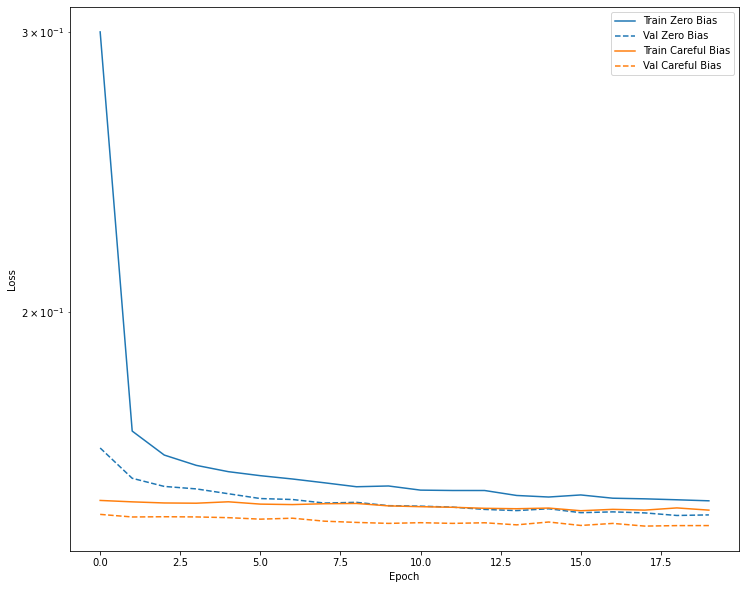

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

# 5. Entrenamiento del modelo y métricas de evaluación

In [ ]:
#Creación y ejecución del modelo
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
884/884 [==============================] - 10s 9ms/step - loss: 0.2122 - tp: 323053.0000 - fp: 65414.0000 - tn: 1751507.0000 - fn: 122326.0000 - accuracy: 0.9170 - precision: 0.8316 - recall: 0.7253 - auc: 0.9632 - prc: 0.8810 - val_loss: 0.1658 - val_tp: 72188.0000 - val_fp: 12718.0000 - val_tn: 350949.0000 - val_fn: 16605.0000 - val_accuracy: 0.9352 - val_precision: 0.8502 - val_recall: 0.8130 - val_auc: 0.9738 - val_prc: 0.9082
Epoch 2/100
884/884 [==============================] - 5s 6ms/step - loss: 0.1679 - tp: 281547.0000 - fp: 54098.0000 - tn: 1399156.0000 - fn: 75039.0000 - accuracy: 0.9286 - precision: 0.8388 - recall: 0.7896 - auc: 0.9735 - prc: 0.9085 - val_loss: 0.1585 - val_tp: 73341.0000 - val_fp: 13434.0000 - val_tn: 350233.0000 - val_fn: 15452.0000 - val_accuracy: 0.9362 - val_precision: 0.8452 - val_recall: 0.8260 - val_auc: 0.9762 - val_prc: 0.9174
Epoch 3/100
884/884 [==============================] - 5s 5ms/step - loss: 0.1620 - tp: 286214.0000 - fp: 55

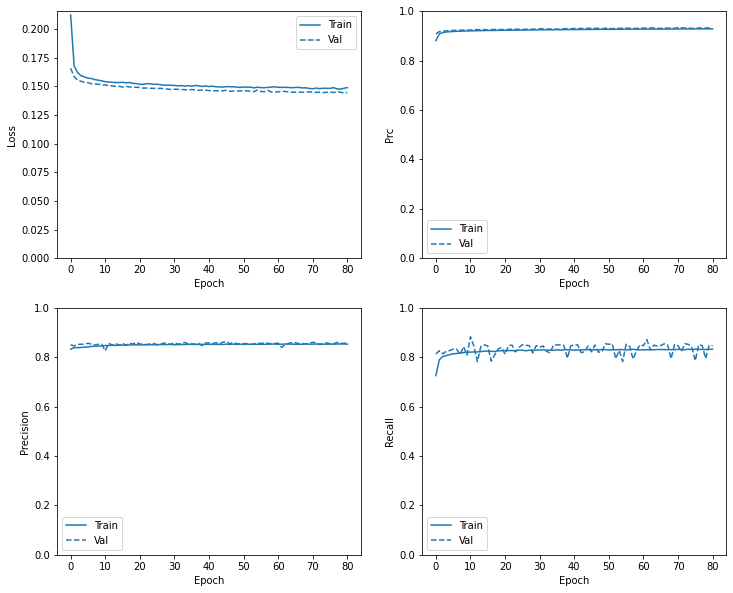

In [ ]:
#Graficando métricas
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

277/277 [==============================] - 0s 1ms/step


In [ ]:
def matriz(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


loss :  0.14492566883563995
tp :  94498.0
fp :  15309.0
tn :  439090.0
fn :  16679.0
accuracy :  0.9434417486190796
precision :  0.8605826497077942
recall :  0.849977970123291
auc :  0.9812352061271667
prc :  0.9340665340423584

Legitimate Transactions Detected (True Negatives):  439090
Legitimate Transactions Incorrectly Detected (False Positives):  15309
Fraudulent Transactions Missed (False Negatives):  16679
Fraudulent Transactions Detected (True Positives):  94498
Total Fraudulent Transactions:  111177


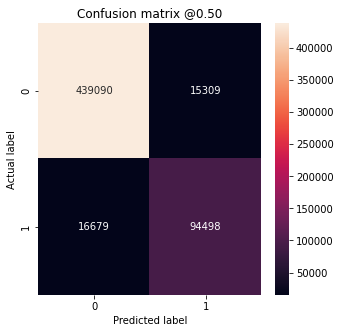

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
  
print()

plot_cm(test_labels, test_predictions_baseline)